In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
# https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.linear_reset.html
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", 4)
pd.set_option("display.max_columns", 11)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.float_format = '{:.4f}'.format

In [2]:
def print_range(df):
    print("S:", df["S"].min(), df["S"].max())
    print("K:", df["K"].min(), df["K"].max())
    print("T:", df["T"].min(), df["T"].max())
    print("r:", df["r"].min(), df["r"].max())
    print("IV:", df["IV"].min(), df["IV"].max())

**迴歸3-模型錯誤設定(Model misspecification)作業**

建立2個迴歸模型，model1為C與S簡單迴歸，model2多了S的二次項，畫出散布圖與回歸線圖，並利用RESET檢定檢查兩個模型是否有模型錯誤設定。

範例為Put，作業請用Call。

* 試驗一: 價內樣本
* 試驗一: 價平樣本
* 試驗一: 價外樣本


# **1. 試驗一: 價內**


## 範例: Put

固定K=12,000，篩選出Put價內區間9,000~11,000、T>0.1、r<0.8%的樣本，建立以下兩個模型，畫出散布圖與回歸線圖，並利用RESET檢定檢查兩個模型是否有模型錯誤設定。

$$
\begin{align}

model \space 1: \space C, P &= \beta_{0} + \beta_{1} \space S \\

model \space 2: \space C, P &= \beta_{0} + \beta_{1} \space S  + \beta_{2} \space S^2 
 
\end{align} 
$$

S: 8890.03 18034.19
K: 12000.0 12000.0
T: 0.1013698630136986 0.7479452054794521
r: 0.00795 0.00795
IV: 0.21672 0.781341


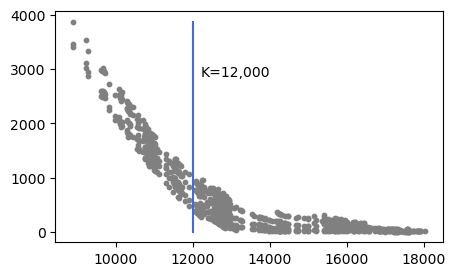

In [3]:
# 全部區間: 價內 價平 價外
dfput = pd.read_csv("TXOPut.csv")
filt = dfput.query("K==12000 & T > 0.1 & r < 0.008") # 價內
plt.figure(figsize=(5,3))
plt.plot([12000,12000], [filt["Put"].min(),filt["Put"].max()], color="royalblue")
plt.text(12200, filt["Put"].max()-1000, "K=12,000")
plt.scatter(filt["S"], filt["Put"], label="Data", c='gray', s=10)
print_range(filt)

In [4]:
# 試驗一範例: 價內Put
dfput = pd.read_csv("TXOPut.csv")
filt1 = dfput.query("K==12000 & S> 9000 & S<11000 & T > 0.1 & r < 0.008") # 價內

# model 1 X:S,    Y: Put
col_list1 = ["S"]
model1 = sm.OLS(filt1["Put"], sm.add_constant(filt1[col_list1])).fit()

# model 2 X:S S2,    Y: Put
col_list2 = ["S","S2"] 
model2 = sm.OLS(filt1["Put"], sm.add_constant(filt1[col_list2])).fit()

print("model1 R2: {:.4f}".format(model1.rsquared))
print("model2 R2: {:.4f}".format(model2.rsquared))

# model summary table
summary_table = model1.summary().tables[1]
summary_table = list(zip(*summary_table.data))
df_table1 = pd.DataFrame({ "coef": summary_table[1][1:],
                          "p值": summary_table[4][1:]}, index=["const"]+col_list1)
                          
summary_table = model2.summary().tables[1]
summary_table = list(zip(*summary_table.data))
df_table2 = pd.DataFrame({ "coef": summary_table[1][1:],
                          "p值": summary_table[4][1:]}, index=["const"]+col_list2)
df_all = pd.concat([df_table1, df_table2], axis="columns", keys=["model1", "model2"]).fillna("")
df_all

model1 R2: 0.8055
model2 R2: 0.8056


model1              model2        
             coef      p值        coef      p值
const   1.172e+04   0.000   1.301e+04   0.111
S         -0.9336   0.000     -1.1854   0.456
S2                          1.228e-05   0.874

<Figure size 600x400 with 0 Axes>

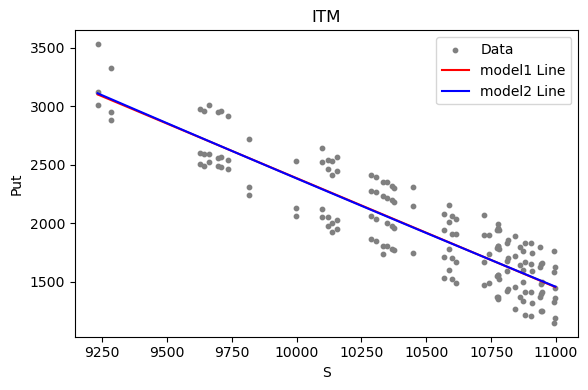

In [5]:
# 2D圖 x軸:S, y軸:Put
plt.figure(figsize=(6, 4))
x = np.linspace(filt1["S"].min(), filt1["S"].max(), 100)
dfx = pd.DataFrame([x, x**2, x**3, x**4, x**5], index=["S","S2","S3","S4","S5"]).T
y1 = model1.predict(sm.add_constant(dfx[col_list1]))
y2 = model2.predict(sm.add_constant(dfx[col_list2]))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
axes.scatter(filt1["S"], filt1["Put"], label="Data", c='gray', s=10)
axes.plot(x, y1, "r", label="model1 Line")
axes.plot(x, y2, "b", label="model2 Line")
axes.set_xlabel("S")
axes.set_ylabel("Put")
axes.legend()
axes.set_title("ITM")
plt.tight_layout()
plt.show()

In [6]:
# RESET檢定
reset1 = linear_reset(model1, power=3, test_type='fitted',use_f=bool,cov_type='nonrobust',cov_kwargs=None)
if reset1.pvalue < 0.05:
    print("model1 存在模型設定錯誤, RESET p-value: ", reset1.pvalue)
else:
    print("model1 不存在模型設定錯誤, RESET p-value: ", reset1.pvalue)
reset2 = linear_reset(model2, power=3, test_type='fitted',use_f=bool,cov_type='nonrobust',cov_kwargs=None)
if reset2.pvalue < 0.05:
    print("model2 存在模型設定錯誤, RESET p-value: ", reset2.pvalue)
else:
    print("model2 不存在模型設定錯誤, RESET p-value: ", reset2.pvalue)

model1 不存在模型設定錯誤, RESET p-value:  0.42134256239829815
model2 不存在模型設定錯誤, RESET p-value:  0.11999920646505946


## Call

固定K=13,000，篩選出Call價內區間14,000~16,000、T>0.1、r<0.8%的樣本，建立以下兩個模型，畫出散布圖與回歸線圖，並利用RESET檢定檢查兩個模型是否有模型錯誤設定。

$$
\begin{align}

model \space 1: \space C, P &= \beta_{0} + \beta_{1} \space S \\

model \space 2: \space C, P &= \beta_{0} + \beta_{1} \space S  + \beta_{2} \space S^2 
 
\end{align} 
$$

S: 8890.03 18526.35
K: 13000.0 13000.0
T: 0.1013698630136986 0.7479452054794521
r: 0.00795 0.00795
IV: 0.000885 0.456325


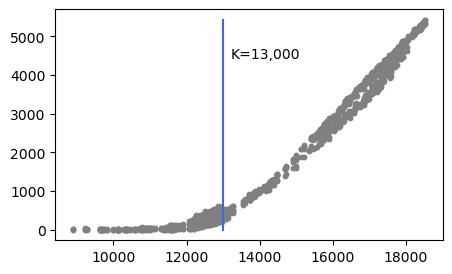

In [7]:
# 全部區間: 價內 價平 價外
dfcall = pd.read_csv("TXOCall.csv")
filt = dfcall.query("K==13000 & T > 0.1 & T > 0.1 & r < 0.008") # 全部區間
plt.figure(figsize=(5,3))
plt.plot([13000,13000], [filt["Call"].min(),filt["Call"].max()], color="royalblue")
plt.text(13200, filt["Call"].max()-1000, "K=13,000")
plt.scatter(filt["S"], filt["Call"], label="Data", c='gray', s=10)
print_range(filt)

In [8]:
# 試驗一: 價內Call


In [9]:
# 2D圖 x軸:S, y軸:Call


In [10]:
# RESET檢定


# **2. 試驗二: 價平**

## Call

固定K=13,000，篩選出Call價平區間12,000~14,000、T>0.1、r<0.8%的樣本，建立以下兩個模型，畫出散布圖與回歸線圖，並利用RESET檢定檢查兩個模型是否有模型錯誤設定。

$$
\begin{align}

model \space 1: \space C, P &= \beta_{0} + \beta_{1} \space S \\

model \space 2: \space C, P &= \beta_{0} + \beta_{1} \space S  + \beta_{2} \space S^2 
 
\end{align} 
$$

In [11]:
# 試驗二: 價平Call


In [12]:
# 2D圖 x軸:S, y軸:Call


In [13]:
# RESET檢定


# **3. 試驗三: 價外**

## Call

固定K=13,000，篩選出Call價外區間10,000~12,000、T>0.1、r<0.8%的樣本，建立以下兩個模型，畫出散布圖與回歸線圖，並利用RESET檢定檢查兩個模型是否有模型錯誤設定。

$$
\begin{align}

model \space 1: \space C, P &= \beta_{0} + \beta_{1} \space S \\

model \space 2: \space C, P &= \beta_{0} + \beta_{1} \space S  + \beta_{2} \space S^2 
 
\end{align} 
$$

In [14]:
# 試驗三: 價外Call


In [15]:
# 2D圖 x軸:S, y軸:Call


In [16]:
# RESET檢定
